In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys 
from skimage import data, io, filters
import configparser
import pandas as pd 
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from matplotlib import cycler
from os.path import join as oj
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pickle as pkl
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sys.path.insert(0, "../src")

from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import my_data
from utils.dice_score import dice_loss
from evaluate import evaluate, aq_cost_function_loader
from unet import UNet
from predict import predict_img
import seaborn as sns
import pickle as pkl
pd.set_option('display.float_format', lambda x: '%.2f' % x)
cuda = False # torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 
from torch.nn import functional as F

In [2]:
fnames = sorted([oj(config['PATHS']['model_path'] , fname) for fname in os.listdir(config['PATHS']['model_path'] ) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 


In [3]:
results = pd.concat(results_list, axis=1).T.infer_objects()

results.experiment_name.unique()
results['best_val_score'] = [max(x) for x in results.val_scores]

In [4]:
results.experiment_name.unique()

array(['LNOActive2', 'FirstTrial', 'LNODrillingdown', 'LNOActive'],
      dtype=object)

In [5]:
# results = results[results.foldername == "lno_halfHour"]
results = results[results.experiment_name == "LNOActive2"]
results = results.reset_index()

In [9]:
results[['foldername', 'best_val_score', 'final_dice_score','cost_function', 'add_ratio']]

,foldername,best_val_score,final_dice_score,cost_function,add_ratio
0,lno_halfHour,0.59,0.00,Mean,0.00
1,lno_halfHour,0.61,0.00,Random,0.00
2,lno_halfHour,0.59,0.00,Random,0.10
3,lno_halfHour,0.58,0.00,Mean,0.10


In [10]:
results.final_dice_score

0   0.00
1   0.00
2   0.00
3   0.00
Name: final_dice_score, dtype: float64

In [18]:
best_idx = 0 #results.best_val_score.argmax()


In [19]:
# need num classes

In [20]:
net = UNet(1, results.num_classes[best_idx], bilinear = results.bilinear[best_idx]).to(device)

In [21]:

# my_models = [UNet(1, 3, bilinear = results_all.bilinear[0]).to(device) for i, _ in enumerate(results.file_name)] 

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] ,results.file_name[best_idx]+".pt")))
net = net.to(device).eval()

In [22]:
x,y,num_classes = my_data.load_layer_data(oj(data_path, results.foldername[best_idx]))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]



In [23]:
img_idx = 2
test_img_np  = ((x[val_idxs[img_idx]][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]

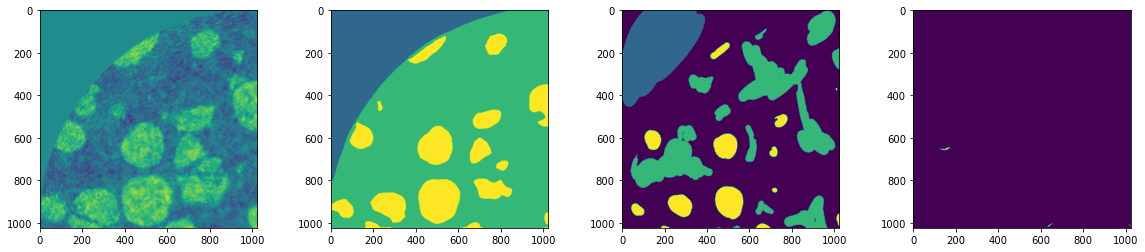

In [24]:
fig, axes = plt.subplots(ncols = 4, figsize = (20,4))
axes[0].imshow(x[val_idxs[img_idx]][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[val_idxs[img_idx]]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ) * (target !=-1))
# axes[1].imshow()

# try with detailed

In [111]:
x,y,num_classes = my_data.load_layer_data(oj(data_path, 'lno'))

x, y = x[:-4], y[:-4]  # just don't touch the last four
x = x/x.max()
val_percent = .25
init_train_ratio =1
image_size = 128
offset = 64
all_idxs = np.arange(len(x))
np.random.seed(0)
np.random.shuffle(all_idxs)
n_val = np.maximum(int(len(x) * val_percent), 1)
n_train = len(x) - n_val
all_train_idxs = all_idxs[:n_train]
val_idxs = all_idxs[n_train:]
init_train_idxs = all_train_idxs[: np.maximum(1, int(init_train_ratio * n_train))]
pool_idxs = all_train_idxs[np.maximum(1, int(init_train_ratio * n_train)) :]

val_set = TensorDataset(
    *[
        torch.Tensor(input)
        for input in my_data.make_dataset(
            x[val_idxs[:1]],
            y[val_idxs[:1]],
            img_size=image_size,
            offset=image_size,
        )
    ]
)
val_loader = DataLoader(val_set, shuffle=False, drop_last=False, batch_size = 16)

In [119]:
ah = evaluate(net, val_loader,device, num_classes)

In [120]:
ah

tensor(0.8179)

In [113]:
test_old_ids

array([1124, 1122, 1121, ...,  789,  831,  832], dtype=int64)

In [99]:
len(val_idxs)

5

In [114]:
len(val_loader.dataset)

64

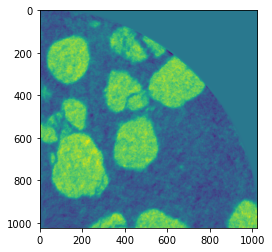

In [115]:
plt.imshow(x[val_idxs[0]][0])

In [116]:
test_ids_safe = aq_cost_function_loader(net, device,val_loader,)

test_ids = np.argsort(test_ids_safe)

In [118]:
len(test_ids)

64

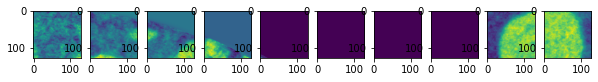

In [117]:
fig, axes = plt.subplots(ncols = 10, figsize = (10,2))
for i in range(10):
    axes[i].imshow(val_set[i][0][0])

In [ ]:
x[val_idxs[0]]

In [77]:
test_ids

array([0.57435375, 0.57165664, 0.56768847, ..., 0.57407802, 0.57407802,
       0.57407802])

In [88]:
len(val_set)

1125

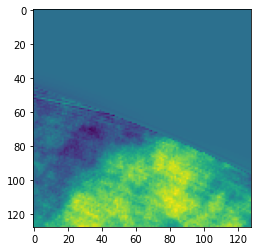

In [108]:
plt.imshow(val_set[5][0][0])

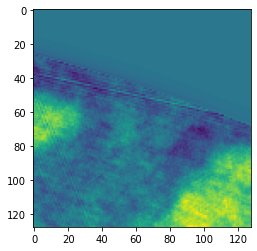

In [107]:
plt.imshow(val_set[4][0][0])

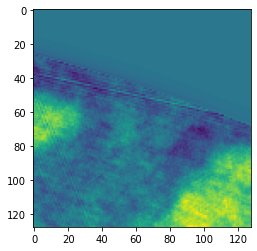

In [91]:
plt.imshow(val_set[4][0][0])

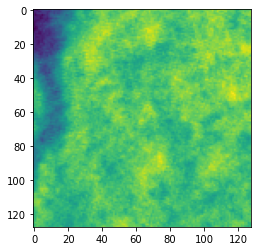

In [87]:
plt.imshow(val_set[test_ids[400]][0][0])

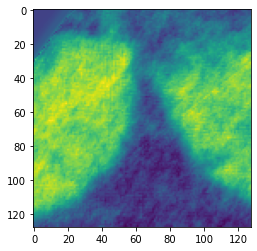

In [84]:
plt.imshow(val_set[test_ids[0]][0][0])

In [81]:
net(val_set[test_ids[0]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

tensor(1.1761, grad_fn=<MeanBackward1>)

In [69]:
net(val_set[test_ids[1]][0][None,:].to(device))[0].std(dim=1).mean(dim=(0,1))

tensor(1.3525, grad_fn=<MeanBackward1>)

In [50]:
test_ids_safe[224]

0.0

tensor([[[[0.4431, 0.4353, 0.4118,  ..., 0.6353, 0.6314, 0.6471],
          [0.4667, 0.4745, 0.4275,  ..., 0.6471, 0.6471, 0.6471],
          [0.4510, 0.4392, 0.4392,  ..., 0.6157, 0.6392, 0.6353],
          ...,
          [0.4000, 0.3843, 0.3961,  ..., 0.8196, 0.8275, 0.7922],
          [0.3765, 0.3922, 0.4000,  ..., 0.8039, 0.8196, 0.7882],
          [0.3843, 0.3843, 0.3569,  ..., 0.8235, 0.8078, 0.8039]]]])

In [46]:
test_ids = np.sort(test_ids)

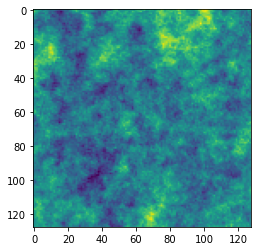

In [55]:
plt.imshow(val_set[test_ids[224]][0][0])

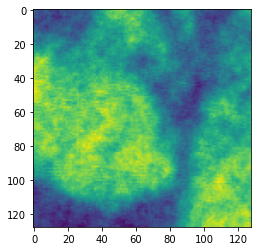

In [51]:
plt.imshow(val_set[test_ids[1]][0][0])

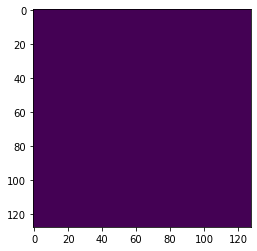

In [30]:
plt.imshow(val_set[test_ids[0]][0][0])

In [184]:
img_idx = 0
test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = F.softmax(net.forward(img_t)[0], dim =0).cpu().detach().numpy()


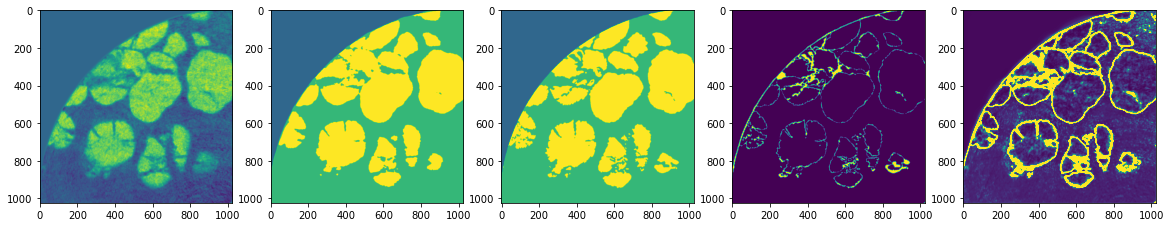

In [185]:
fig, axes = plt.subplots(ncols = 5, figsize = (20,4))
axes[0].imshow(x[img_idx][0])
axes[1].imshow(np.argmax(output, axis=0),vmin =-1, vmax = 2)
target = np.copy(y[img_idx]).astype(np.int16)
target[np.where(target == 255)] =-1
axes[2].imshow(target, vmin =-1,vmax = 2)
axes[3].imshow((target !=np.argmax(output, axis=0) ))
max_val =np.quantile(output.std(axis=0).max() - output.std(axis=0),.90)
axes[4].imshow(output.std(axis=0).max() - output.std(axis=0),vmax = max_val)
# axes[1].imshow()

In [ ]:
output.std(axis=0).max() - output.std(axis=0)

In [111]:
with torch.no_grad():
    img_t = torch.Tensor(x[val_idxs]).to(device)
    output = F.softmax(net.forward(img_t), dim =1)


In [122]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

0.8699781417846679

In [129]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std < np.quantile(my_std, .1)))].mean()

0.2302288631989731

In [142]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs])[np.where((my_std > np.quantile(my_std, .1)))].mean()

0.9410618426267169

In [138]:
len(val_loader)

[autoreload of evaluate failed: Traceback (most recent call last):
  File "C:\Users\lauri\Miniconda3\envs\my_science\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\lauri\Miniconda3\envs\my_science\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\lauri\Miniconda3\envs\my_science\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\lauri\Miniconda3\envs\my_science\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_remove

28

In [ ]:
val_loader

In [ ]:
eva

In [120]:
my_std = torch.std(output,dim =1).detach().cpu().numpy()

In [ ]:
torch.argmax(output, dim = 1)

In [121]:
np.where((my_std < np.quantile(my_std, .1)))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False,  True]],

       [[ True,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False,  True]],

       [[ True,  True, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [117]:
(torch.argmax(output, dim = 1).detach().cpu().numpy() ==y[val_idxs]).mean()

0.8699781417846679

In [ ]:
output.shape

In [106]:
1-dice_loss(output, torch.Tensor(y[val_idxs]).to(device), num_classes, multiclass=True)

tensor(0.8587)

In [21]:
from dice_score import dice_loss

ModuleNotFoundError: No module named 'dice_score'

In [ ]:
dice_loss()

In [22]:
num_classes

3

In [ ]:
np.quantile(output.std(axis=0).max() - output.std(axis=0), .9)

In [ ]:
output.std(axis=0).max()

In [ ]:
(target ==np.argmax(output, axis=0) ).mean()

In [ ]:
output.std(axis=0)

# old stuff

In [ ]:
for i in range(4):
    img_idx = i
    test_img_np  = ((x[img_idx][None, ].astype(np.float32) ))
    with torch.no_grad():
        img_t = torch.Tensor(test_img_np).to(device)
        output = net.forward(img_t).cpu().detach().numpy()[0]
        show_img = np.zeros_like(y[img_idx])
        show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
        show_img[np.where(y[img_idx] ==my_data.phase_2)] =2
        print((show_img ==np.argmax(output, axis=0)).mean())


In [ ]:
img_idx = -1
test_img_np  = ((x[img_idx][None, ].astype(np.float32) -my_data.mean)/my_data.std)
with torch.no_grad():
    img_t = torch.Tensor(test_img_np).to(device)
    output = net.forward(img_t).cpu().detach().numpy()[0]


In [ ]:
show_img = np.zeros_like(y[img_idx])
show_img[np.where(y[img_idx] ==my_data.phase_1)] =1
show_img[np.where(y[img_idx] ==my_data.phase_2)] =2

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .05)

fig, axes = plt.subplots(ncols = 3, figsize = (20,8))
# axes[0].imshow(x[img_idx,2])
axes[0].imshow(np.argmax(output, axis=0))
# axes[2].imshow(show_img)
axes[1].imshow(show_img !=np.argmax(output, axis=0) )

axes[2].imshow(std_large)

In [ ]:
(show_img !=np.argmax(output, axis=0))[np.where(1-std_large)].mean()

In [ ]:
(show_img ==np.argmax(output, axis=0)).mean()

In [ ]:
correct = np.reshape(show_img !=np.argmax(output, axis=0),-1)
std = np.reshape(output.std(axis=0), -1)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 5, figsize = (20,7))
axes[0].imshow(x[img_idx,2])
axes[1].imshow(np.argmax(output, axis=0))
axes[2].imshow(show_img)
axes[3].imshow(show_img !=np.argmax(output, axis=0) )

axes[4].imshow(std_large)

In [ ]:
std_large = output.std(axis=0)<np.quantile(output.std(axis=0), .1)

fig, axes = plt.subplots(ncols = 1, figsize = (20,7))
axes.imshow(x[img_idx,2][200:400,350:600])

# axes[4].imshow(std_large)

In [ ]:
x.shape

In [ ]:
plt.imshow(x[0,2])

In [ ]:
plt.imshow(x[-1,2])

In [ ]:
x[img_idx,2][200:400,350:600]